In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

%matplotlib inline

# Import TFIDF vectorizer from SciKit-Learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Import similarity distance metrics from SciKit-Learn
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

You can download the dataset to your current working folder using command line and valid URL:

`!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv`

The dataset lists individual movies with popularity ratings, revenue, number of spoken languages, vote average, vote count, and many more features. 

The point of a **recommender system** is that you do not have target labels by which to categorise your films, because you are building a recommendation model that makes suggestions based on selected features and their similarity.

In this exercise, you will build a recommendation system that accepts a movie title as the query, and returns the top 5 titles of the most similar movies.

Metadata for the dataset can be accessed from [here](https://www.kaggle.com/tmdb/tmdb-movie-metadata).

# Explore data and select feature text columns

In [2]:
df = pd.read_csv('data/tmdb_5000_movies.csv')

In [26]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,text
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy ScienceFiction cultur...
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Adventure Fantasy Action ocean drugabuse exoti...
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime spy basedonnovel secret...
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller dccomics crimefigh...
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure ScienceFiction basedonnovel m...


In [4]:
# Popularity is measured in what???!
# There are 37 original language values (categorical variable)
# Ignore homepage and tagline data

In [5]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [6]:
# 4,803 movies

df.shape

(4803, 20)

In [7]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [8]:
df.iloc[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [9]:
# Keywords entered as values under the dictionary key "name" - valid JSON string

df['keywords'][0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [10]:
# Genres entered as values under the dictionary key "name" - valid JSON string

df['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [11]:
type(df['genres'][0])

str

In [12]:
# Convert 'genres' JSON string to Python dictionary

x = df.iloc[0]

# json.loads() takes in valid JSON string and converts to Python dictionaries contained in list
j = json.loads(x['genres'])

In [13]:
j

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [14]:
type(j[0])

dict

In [15]:
# Loop through list and join 'name' values with whitespace and join any words within each genre without whitespace, 
# e.g. 'Science Fiction' becomes 'ScienceFiction', i.e. a single token
# NOTE THERE ARE NO COMMAS - each string is treated as one token

' '.join(''.join(jj['name'].split()) for jj in j)

'Action Adventure Fantasy ScienceFiction'

In [17]:
''' CONVERT 'genres' FOR EACH MOVIE TO SINGLE STRING 
    CONVERT 'keywords' FOR EACH MOVIE TO SINGLE STRING
    COMBINE BOTH STRINGS IN FINAL OUTPUT '''

def genres_and_keywords_to_string(row): 
    
    # Convert to Python dict and join genre names in single string
    genres = json.loads(row['genres']) 
    genres = ' '.join(''.join(j['name'].split()) for j in genres) 
    
    # Convert to Python dict and join keyword names in single string
    keywords = json.loads(row['keywords']) 
    keywords = ' '.join(''.join(j['name'].split()) for j in keywords) 
    return "%s %s" % (genres, keywords)


In [18]:
genres_and_keywords_to_string(df.iloc[0])

'Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d'

In [19]:
# Create new text column using function above to combine genre and keyword strings 

df['text'] = df.apply(genres_and_keywords_to_string, axis=1)

In [20]:
df[['title', 'text']].head()

,title,text
0,Avatar,Action Adventure Fantasy ScienceFiction cultur...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drugabuse exoti...
2,Spectre,Action Adventure Crime spy basedonnovel secret...
3,The Dark Knight Rises,Action Crime Drama Thriller dccomics crimefigh...
4,John Carter,Action Adventure ScienceFiction basedonnovel m...


In [21]:
df['text'].iloc[369]

"Action Adventure Fantasy Thriller riddle treasure medallion kenia alexanderthegreat pandora'sbox chinesemafia treasurehunt hongkong archaeologist basedonvideogame archeology"

In [22]:
df['title'].iloc[369]

'Lara Croft Tomb Raider: The Cradle of Life'

# Vectorize text column with TF-IDF vectorizer

You want your recommender system to have access to the entire database when making 'suggestions' based on similarity, so do not train-test-split your data (especially as there are no target labels involved so no performance measures needed).

In [23]:
# Instantiate vectorizer object (previously done with 9789 features in total)

tfidf = TfidfVectorizer(max_features=8000)

In [24]:
# Train vectorizer and create sparse matrix

X = tfidf.fit_transform(df['text'])

In [27]:
# 4,803 movies and 8,000 words (under max_features)

X

<4803x8000 sparse matrix of type '<class 'numpy.float64'>'
	with 46974 stored elements in Compressed Sparse Row format>

You are now working with a **sparse matrix** of numbers, so you cannot tell which movie corresponds to what row. Remember that the data has been processed in the same order it was input with, so the sparse matrix row order will match the movie title order in the data. 

**Create a variable that maps each movie title to an index::**

In [28]:
# Create Series variable mapping movie title -> index (taken from df)

movie2id = pd.Series(df.index, index=df['title'])

In [29]:
movie2id

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [30]:
movie2id['Scream 3']

1164

In [31]:
movie2id['The Matrix']

634

# Create your query (select individual movie title)

In [32]:
# Find 'Scream 3' TF-IDF vector by locating its row index number

idx = movie2id['Scream 3']

idx

1164

In [33]:
# Use row index number to locate row of vectors in sparse matrix

query = X[idx]

query

<1x8000 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [34]:
# View sparse matrix in more friendly array (mostly zeros...)

query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

# Compute cosine similarity between your query and all movies

In [35]:
# Compute cosine similarity between query vector and every vector in X

scores = cosine_similarity(query, X)

In [36]:
scores

array([[0., 0., 0., ..., 0., 0., 0.]])

In [37]:
# Ensure it is just 1-D array
scores = scores.flatten()

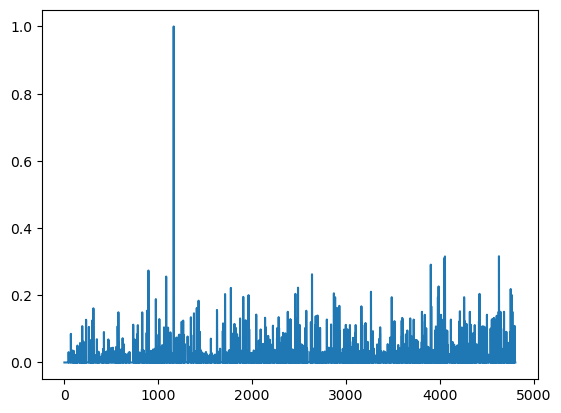

In [38]:
plt.plot(scores);

In [ ]:
# The big spike is the maximum similarity of 1, which is query vector similarity with itself!
# A lot of variation in similarity values with other movies

In [39]:
# Sort similarity scores in descending order (most similar to least similar)
# Use argsort() to return the index number when sorted by the scores

(-scores).argsort()

array([1164, 4628, 4053, ..., 1715, 1721, 4802], dtype=int64)

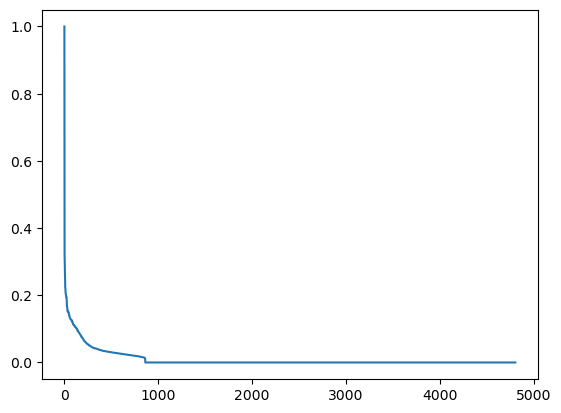

In [40]:
plt.plot(scores[(-scores).argsort()]);

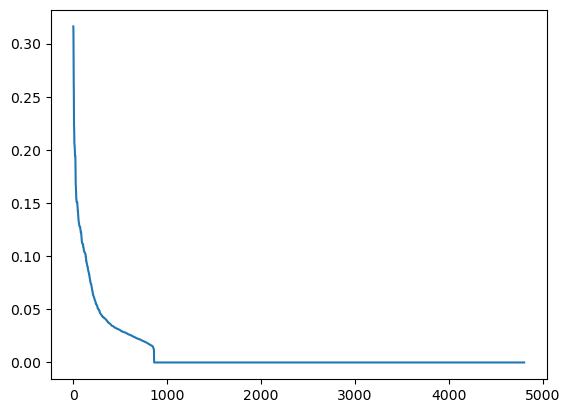

In [41]:
# Note that similarity between the query and itself in list of movies will yield maximum score (1.0) - this should be removed:

plt.plot(scores[(-scores).argsort()[1:]]);

In [ ]:
# Highest similarity just above 0.3, with majority of movies having nothing in common at all with Scream 3 (all zeros)

# Extract top 5 movie titles most similar to your query

In [42]:
# Extract top 5 row indices when sorted by similarity in descending order (remove 1st value)

recommended_idx = (-scores).argsort()[1:6]

recommended_idx

array([4628, 4053, 4048, 3902,  895], dtype=int64)

In [43]:
# Use row indices to search through the titles in df

df['title'].iloc[recommended_idx]

4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
3902    Friday the 13th Part VI: Jason Lives
895                       Me, Myself & Irene
Name: title, dtype: object

In [44]:
# The 5 most similar movies to Scream 3! Do not understand why Me, Myself & Irene is there...it is dark comedy...
# Maybe data does not have enough horror movie examples but that seems doubtful.

In [47]:
''' FUNCTION TO GENERATE RECOMMENDATIONS WHEN MOVIE TITLE USED AS INPUT ARGUMENT
    You must have created mapped movie --> index variable as look-up for movie's row index '''


def recommend(title): 
    
    # Get row in the df for this movie 
    idx = movie2id[title] 
    if type(idx) == pd.Series: 
        idx = idx.iloc[0]
        
    # Calculate pairwise similarities for this movie 
    query = X[idx] 
    scores = cosine_similarity(query, X) 
    
    # Currently array is 1 x N, make it 1-D array 
    scores = scores.flatten() 
    
    # Get indices of highest scoring movies 
    # Get the first 5 recommendations (don't return itself!) 
    recommended_idx = (-scores).argsort()[1:6] 
    
    # return the titles of the recommendations 
    return df['title'].iloc[recommended_idx]


In [48]:
print(recommend('Scream 3'))

4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
3902    Friday the 13th Part VI: Jason Lives
895                       Me, Myself & Irene
Name: title, dtype: object


In [49]:
print(recommend('Mortal Kombat'))

1611              Mortal Kombat: Annihilation
1670                       DOA: Dead or Alive
3856              In the Name of the King III
1001    Street Fighter: The Legend of Chun-Li
114       Harry Potter and the Goblet of Fire
Name: title, dtype: object


In [50]:
print(recommend('Runaway Bride'))

4115                     House of D
2325     My Big Fat Greek Wedding 2
971                 The Story of Us
1162    He's Just Not That Into You
4045          Dancer, Texas Pop. 81
Name: title, dtype: object


In [ ]:
# That's more like it!